In [ ]:
import xarray as xr
##Xarray is a powerful library designed for handling labeled multi-dimensional arrays.
##It is particularly useful in scientific computing and data analysis,
##especially for working with datasets that have multiple dimensions
##(our satellite data have minimum of 2 or 3 dimensions (lat/lon or lat/lon/time ...can be more)
import numpy as np
##NumPy is a fundamental package for numerical computing.
##It provides support for arrays and matrices, along with a collection of mathematical functions
##to operate on these data structures efficiently.
import glob
#The glob module provides a way to retrieve files and directories matching a specified pattern.
import os
#The os module offers a way to interact with the operating system.
import warnings
#The warnings module is used to issue warning messages in Python programs
import pandas as pd
#panda help to convert data into dataframes easily

In [ ]:
!pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.4 MB/s eta 0:00:00


In [ ]:
import netCDF4

def print_nc_structure(nc_file):
    def print_group(nc_grp, indent=0):
        prefix = ' ' * indent
        print(f"{prefix}Group: {nc_grp.path}")

        # Print dimensions
        if nc_grp.dimensions:
            print(f"{prefix}  Dimensions:")
            for dim_name, dim in nc_grp.dimensions.items():
                size = len(dim) if not dim.isunlimited() else 'unlimited'
                print(f"{prefix}    {dim_name} = {size}")

        # Print variables
        if nc_grp.variables:
            print(f"{prefix}  Variables:")
            for var_name, var in nc_grp.variables.items():
                dims = ', '.join(var.dimensions)
                print(f"{prefix}    {var_name}({dims})")
                # Print variable attributes
                for attr in var.ncattrs():
                    value = var.getncattr(attr)
                    print(f"{prefix}      {attr} = {value}")

        # Recursively print subgroups
        for subgroup_name, subgroup in nc_grp.groups.items():
            print_group(subgroup, indent + 2)

    # Open the NetCDF file
    with netCDF4.Dataset(nc_file, 'r') as ds:
        print(f"netcdf {ds.filepath()} {{")

        # Print global attributes
        if ds.ncattrs():
            print("  Global Attributes:")
            for attr in ds.ncattrs():
                value = ds.getncattr(attr)
                print(f"    :{attr} = \"{value}\" ;")

        # Print the root group
        print_group(ds)
        print("}")

# Usage
nc_file = "/content/GK2.nc"
print_nc_structure(nc_file)


netcdf /content/GK2.nc {
  Global Attributes:
    :institution = "ESC, Environmental Satellite Center" ;
    :publisher_url = "https://nesc.nier.go.kr/" ;
    :processing_level = "L4" ;
    :product_version = "2.3.4" ;
    :geographic_crs_name = "WGS84" ;
Group: /
  Dimensions:
    spatial = 1239
    image = 619
    importance = 31
  Group: /Geolocation Fields
    Variables:
      Longitude(spatial, image)
        short_name = Longitude
        long_name = Longitude
        units = degree
      Latitude(spatial, image)
        short_name = Latitude
        long_name = Latitude
        units = degree
  Group: /Data Fields
    Variables:
      PM25(spatial, image)
        short_name = PM25
        long_name = Surface PM2.5 Concentrations
        units = ug/m3
        valid_min = 0.0
      SMAPE(spatial, image)
        short_name = SMAPE
        long_name = Symmetric Mean Absolute Percentage Error
        units = %
        valid_min = 0.0
        valid_max = 100.0
      CloudFraction(spat

In [ ]:
# Understanding the NetCDF File Structure
# From the ncdump -h output, our NetCDF file (GK2_GEMS_L4_20241208_0445_PM25-SURFACE_ORI.nc) has the following structure:

# Dimensions:

# spatial = 1239
# image = 619
# importance = 31
# Groups:

# Geolocation Fields
# Variables:
# Longitude(spatial, image)
# Latitude(spatial, image)
# Data Fields
# Variables:
# PM25(spatial, image)
# SMAPE(spatial, image)
# CloudFraction(spatial, image)
# Importance(importance)

In [ ]:
nc_file = "/content/GK2.nc"
# Load the 'Geolocation Fields'
geolocation_fields = xr.open_dataset(nc_file, group='Geolocation Fields', engine='netcdf4')
# Load the 'Data Fields'
data_fields = xr.open_dataset(nc_file, group='Data Fields', engine='netcdf4')
longitude = geolocation_fields['Longitude']
latitude = geolocation_fields['Latitude']
pm25 = data_fields['PM25']
# Combine variables into one Dataset
combined = xr.Dataset({
    'Longitude': longitude,
    'Latitude': latitude,
    'PM2.5': pm25
})
# Convert to DataFrame and reset index to include 'spatial' and 'image'
df = combined.to_dataframe().reset_index()
df
##So now our data is in dataframe format#
#to crosscheck if the geolocation is correct# we can tally these dataframe spatial and image with corresponding
#lat/lon/pm25 with panoply (Its usually not wrong !! Trust me !!)

,spatial,image,Longitude,Latitude,PM2.5
0,0,0,NaN,NaN,NaN
1,0,1,NaN,NaN,NaN
2,0,2,NaN,NaN,NaN
3,0,3,NaN,NaN,NaN
4,0,4,NaN,NaN,NaN
...,...,...,...,...,...
766936,1238,614,NaN,NaN,NaN
766937,1238,615,NaN,NaN,NaN
766938,1238,616,NaN,NaN,NaN
766939,1238,617,NaN,NaN,NaN


In [ ]:
#Lets get rid of NANs
df_clean = df.dropna()
df_clean

,spatial,image,Longitude,Latitude,PM2.5
26772,43,155,98.792229,44.977043,33.318139
26774,43,157,99.026627,44.960865,31.189773
26775,43,158,99.143066,44.952847,35.963811
27366,44,130,95.803581,45.156948,43.510383
27391,44,155,98.817467,44.938595,30.077368
...,...,...,...,...,...
756486,1222,68,102.328621,12.573163,18.305307
756487,1222,69,102.404022,12.571829,19.230473
757104,1223,67,102.255859,12.551466,13.389742
757105,1223,68,102.331596,12.550163,15.163697


In [ ]:
#so lets save the data to csv file
df.to_csv('PM25_Data.csv', index=False)

In [ ]:
!pip install cartopy
import matplotlib.pyplot as plt            # For plotting
import cartopy.crs as ccrs               # For Cartopy projections
import cartopy.feature as cfeature       # For map features like coastlines, borders
import pandas as pd                      # For handling the data (assumed DataFrame)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 85.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Do

Scatter PM2.5 map saved as 'PM25_Map_Scatter_Viridis.png'.


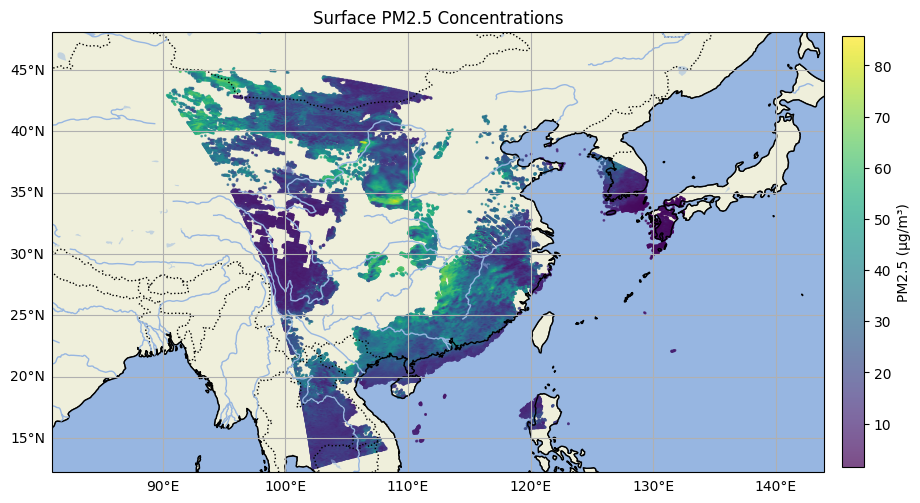

In [ ]:
# Create a figure and an axes with a Cartopy projection
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features for context
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Set the extent of the map based on your data's range
lon_min, lon_max = df['Longitude'].min(), df['Longitude'].max()
lat_min, lat_max = df['Latitude'].min(), df['Latitude'].max()
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Create the scatter plot with viridis colormap
scatter = ax.scatter(
    df['Longitude'],
    df['Latitude'],
    c=df['PM2.5'],
    cmap='viridis',  # Changed from 'Reds' to 'viridis'
    s=1,             # Marker size
    transform=ccrs.PlateCarree(),
    alpha=0.7        # Transparency
)

# Add a colorbar
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02, shrink=0.7)
cbar.set_label('PM2.5 (µg/m³)')

# Add a title
plt.title('Surface PM2.5 Concentrations')

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False

# Save the figure (optional)
plt.savefig('PM25_Map_Scatter_Viridis.png', dpi=300, bbox_inches='tight')
print("Scatter PM2.5 map saved as 'PM25_Map_Scatter_Viridis.png'.")

# Display the plot
plt.show()
##SO that is how we can plot the file#
##The script is prepared by Mr Pravash Tiwari AERSC@CUMT_China##